In [1]:
#import external libraries
import pandas as pd
import os
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt
import calendar

#plotting
%matplotlib notebook

#import my settings
from settings import Glacier, Station, base_path
import CleanWxData as wx

In [2]:
save_plots=True
save_data=True
if Glacier=='Gulkana':
    start_good_overlap_precip_date='2014-07-23'
if Glacier=='Wolverine':
    start_good_overlap_precip_date= '2013-09-13'#'2013-08-28' second is chosen by visual inspection of record

In [3]:
#Read in data
data_dir=base_path +"Data/"+Glacier+ r"/AllYears/Wx/LVL2/emily/"
fl=Glacier.lower()+ Station + "_daily_"+"LVL2.csv"
pth=os.path.join(data_dir, fl)
dat=pd.read_csv(pth)
print("read data from "+ pth)

#Set time index
dat.Date=pd.to_datetime(dat.Date, format='%Y/%m/%d')
dat=dat.set_index('Date')

read data from Q:/Project Data/GlacierData/Benchmark_Program/Data/Sperry/AllYears/Wx/LVL2/emily/sperry2440_daily_LVL2.csv


<IPython.core.display.Javascript object>


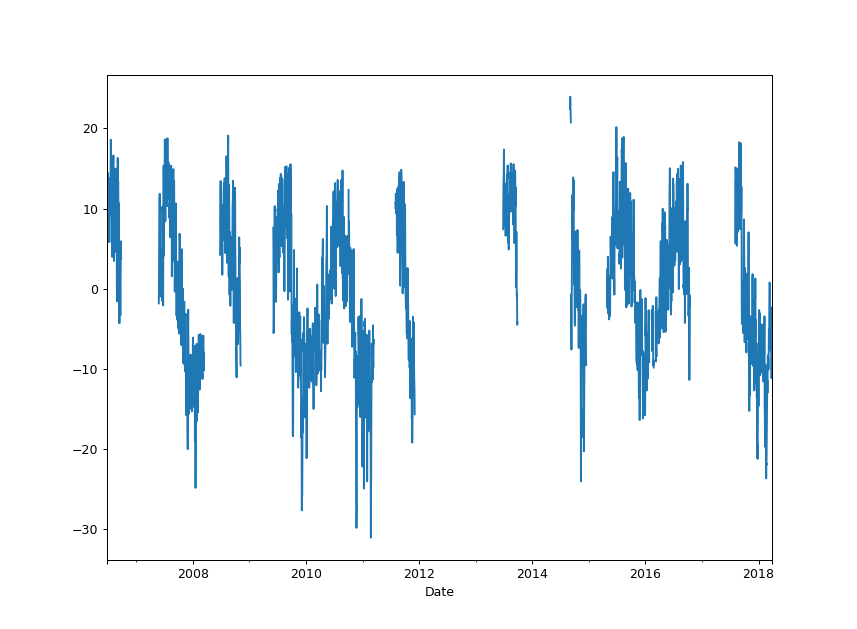

In [4]:
dat.Temp_USGS.plot()

In [8]:
# #Read in raw 15 minute data
raw_dat=pd.read_csv(base_path+ 'Data/' + Glacier+ '/AllYears/Wx/LVL0/emily/' + Glacier.lower() + Station +'_15min_NWIS_1990s_added.csv', infer_datetime_format=True)
raw_dat['local_time']=pd.to_datetime(raw_dat.local_time)
raw_dat=raw_dat.set_index('local_time') 

In [9]:
dat.columns

Index(['Temp_min', 'Temp_max', 'Temp_WMO', 'Temp_USGS', 'Stage_Precip',
       'TPG_Precip', 'RelHum', 'WindSpeed', 'WindGustSpeed', 'RadiationIn',
       'RadiationOut', 'SnowDepth', 'WindDir', 'VecAvgWindDir'],
      dtype='object')

In [13]:
#Give names of temperature and precip columns in level 2 data
temp_col='Temp_USGS'
temp_maxmin_cols=['Temp_min', 'Temp_max']
precip_cols=['Stage_Precip', 'TPG_Precip']
wind_col='WindSpeed'

In [11]:
#Read in historical daily data (from analog strip charts)
GUI_dat=pd.read_csv(base_path.split('/Ben')[0]+ '/Matlab_Files/mb_GUI/2017.06.28/data/' + Glacier+ '/Input/Input_' + Glacier + '_Daily_Weather.csv', infer_datetime_format=True)
GUI_dat['date']=pd.to_datetime(GUI_dat.date, format="%m/%d/%Y")
GUI_dat=GUI_dat.set_index('date')
GUI_dat.columns=['temp_original', 'precip_original']

In [12]:
GUI_dat_og=GUI_dat.copy()

In [13]:
dat_new=dat.copy() #save data w/o older added
start_date_15min_data=dat_new.index[0] #this is the date that we have 15-minute data

In [14]:
start_date_15min_data

Timestamp('1995-10-04 00:00:00')

### Create single continuous precipitation record
#####  First - calculate the scale factor that should be applied to bias-adjust record thru the stage gage -> TPG transition

In [15]:
#Define precip phase
daily_dat=wx.define_precip_phase(dat, 'Temp_USGS') #daily dat is a copy of original; original dat remains unedited

In [16]:
dat.equals(dat_new)

True

In [17]:
#Calculate precip undercatch; ONLY for purpose of deriving scale factor
daily_dat=wx.correct_undercatch_yang98(daily_dat, precip_cols[0], 'phase', 'WindSpeed')
daily_dat=wx.correct_undercatch_yang98(daily_dat, precip_cols[1], 'phase', 'WindSpeed')

<IPython.core.display.Javascript object>


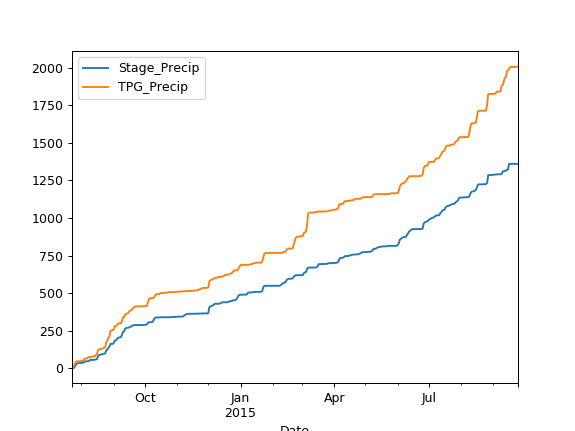

Scale factor = 1.47892652561


In [18]:
daily_dat[precip_cols][start_good_overlap_precip_date: daily_dat[precip_cols[0]].last_valid_index()].cumsum().plot()
ratiodf=daily_dat[precip_cols][start_good_overlap_precip_date: daily_dat[precip_cols[0]].last_valid_index()].cumsum()[-1:]
scale_factor=(ratiodf.TPG_Precip/ratiodf.Stage_Precip).values[0]
print("Scale factor = " + str(scale_factor))

### Bias-adjust stage gage data to match TPG

In [19]:
#Merge older pre-digital data with new 15-min derived daily data
dat=GUI_dat[['temp_original', 'precip_original']].merge(dat[[temp_col]+ precip_cols+[wind_col]+temp_maxmin_cols], left_index=True, right_index=True, how='outer')

In [20]:
#Bias adjustment
dat['Precipitation']=pd.np.nan
dat['stage_adjusted']=dat.Stage_Precip*scale_factor #Adjusted by factor of 5 to account for orifice size, and *2 for wind factor (empirical)
dat['original_adjusted']=dat.precip_original*scale_factor
#Create full record from 3 pieces
dat.loc[start_good_overlap_precip_date:,'Precipitation']=dat.loc[start_good_overlap_precip_date:,'TPG_Precip'] #precip is TPG from install -> end
dat.loc[dat.stage_adjusted.first_valid_index():start_good_overlap_precip_date,'Precipitation']=dat.loc[dat.stage_adjusted.first_valid_index():start_good_overlap_precip_date,'stage_adjusted']#precip is adjusted stage (made from 15 min) back to late 2003
dat.loc[:dat.stage_adjusted.first_valid_index(),'Precipitation']=dat.loc[:dat.stage_adjusted.first_valid_index(),'original_adjusted']#precip is adjusted stage (made from 15 min) back to late 2003

<IPython.core.display.Javascript object>


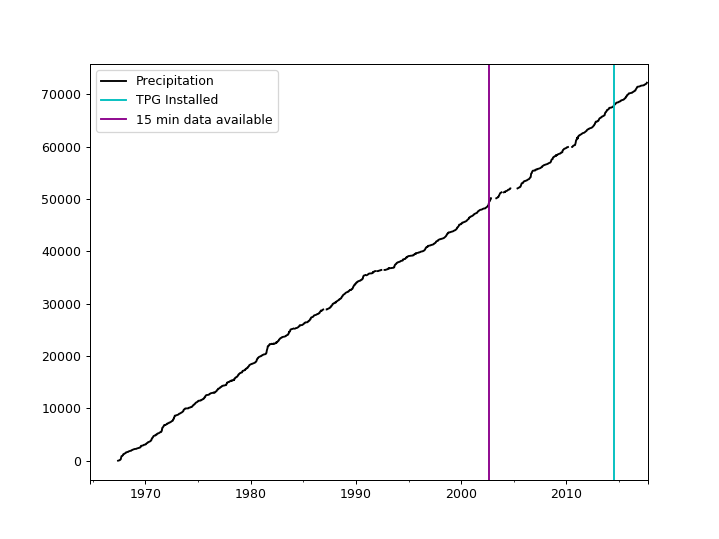

In [21]:
#How does this look for a continuous precip record
plt.figure(figsize=(8,6))
dat.Precipitation.cumsum().plot(color='black')
plt.axvline(x=start_good_overlap_precip_date, color='c', label="TPG Installed")
plt.axvline(x=dat.stage_adjusted.first_valid_index(), color='darkmagenta',label="15 min data available")
plt.legend()
if save_plots:
    strFile = './figs/' + Glacier+Station+ '/precip_match/' + Glacier + Station+ '_Different_Eras_Of_Precip_Record.jpg'
    if os.path.isfile(strFile):
       os.system("rm "+strFile)
    plt.savefig(strFile)

In [22]:
#Create single continuous temperature record
dat['Temperature']=dat['Temp_USGS']

dat.loc[(dat.Temp_USGS.isnull()) & (dat.index<start_date_15min_data), 'Temperature']=dat.loc[(dat.Temp_USGS.isnull()) & (dat.index<start_date_15min_data), 'temp_original']

In [23]:
start_date_15min_data

Timestamp('1995-10-04 00:00:00')

## Save data

In [24]:
dat.head()

,temp_original,precip_original,Temp_USGS,Stage_Precip,TPG_Precip,WindSpeed,Temp_min,Temp_max,Precipitation,stage_adjusted,original_adjusted,Temperature
1964-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
save_dat=dat[['Temperature', 'Precipitation']]
save_dat.plot()

KeyError: "['Temperature' 'Precipitation'] not in index"

In [26]:
save_data=True

In [27]:
if save_data:
    save_dat.loc[:,'Temperature']=["%.1f" %x for x in save_dat.Temperature]
    save_dat.loc[:,'Precipitation']=["%.1f" %x for x in save_dat.Precipitation]
    save_dat.index.name='Date'
    save_pth=base_path + '/Data/' + Glacier + '/AllYears/Wx/LVL3/Input_' + Glacier + '_Daily_Weather_emily.csv'
    save_dat.to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


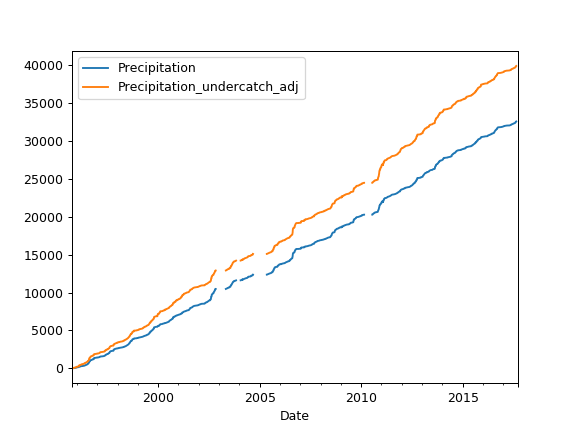

In [28]:
#Adjust recent data by wind speed, and save just this recent adjusted data
dat_recent=wx.define_precip_phase(dat[dat.WindSpeed.first_valid_index():].copy(), 'Temperature') #daily dat is a copy of original; original dat remains unedited

#Calculate precip undercatch, using CONSTANT yearly pattern of wind speed
dat_recent=wx.correct_undercatch_yang98(dat_recent, 'Precipitation', 'phase', 'WindSpeed', inplace=False)
dat_recent[['Precipitation', 'Precipitation_undercatch_adj']].cumsum().plot()

#Save this adjusted data
if save_data:
    save_pth=base_path + '/Data/' + Glacier + '/AllYears/Wx/LVL3/OnlyRecentRealWindUndercatch_Adj' + Glacier + '_Daily_Weather.csv'
    dat_recent[dat.WindSpeed.first_valid_index():].to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

### Calculate average wind-speeds, and adjust precipitation by this factor

<IPython.core.display.Javascript object>


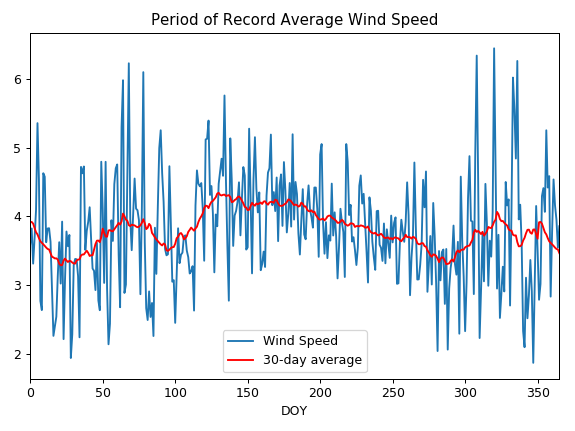

In [29]:
#Stuff to make period-of-record average for Wind Speed!
#Create period-of-record daily average (e.g. avg. on Mar1, Jan3, etc.)
n_window=30
period_of_record_avg_ws=pd.DataFrame(dat[wind_col].groupby([dat.index.month, dat.index.day]).mean())
period_of_record_avg_ws=period_of_record_avg_ws.reset_index()
period_of_record_avg_ws.columns=['month', 'day', wind_col]

period_of_record_avg_ws.index.name='DOY'
period_of_record_avg_ws=period_of_record_avg_ws.reset_index()

period_of_record_avg_ws_r30=period_of_record_avg_ws[wind_col].rolling(n_window, center=True).mean()

#Calculate avg wind speed for periods before and after the moving-window won't b/c DOY 1-365 disconnect
extra_ws=period_of_record_avg_ws.copy()
extra=extra_ws[wind_col][0:n_window]
extra_for_movavg=period_of_record_avg_ws.WindSpeed.append(extra, ignore_index=True)
long_windowavg=extra_for_movavg.rolling(n_window, center=True).mean()
period_of_record_avg_ws_r30[0:int(n_window/2)]=long_windowavg[366:(366+int(n_window/2))] #replace missing portion at beginning
period_of_record_avg_ws_r30[int(366-(n_window/2)):366]=long_windowavg[366:int(366+(n_window/2))] #replace missing portion at end

#Make Plot of this
plt.figure()
period_of_record_avg_ws.index.name='DOY'
ax=period_of_record_avg_ws['WindSpeed'].plot()
period_of_record_avg_ws_r30.plot(ax=ax, color='red')
plt.legend(['Wind Speed', '30-day average'])
plt.title('Period of Record Average Wind Speed')
plt.tight_layout()
plt.savefig('./figs/' + Glacier + Station+ '/trends/' + Glacier + Station+ 'PeriodOfRecordWindSpeed.jpg')

#Add wind speed on day of year to main dataframe
dat['DOY']=dat.index.dayofyear-1
period_of_record_avg_ws_r30.index.name="DOY"
period_of_record_avg_ws_r30.name='WS_Constant'
period_of_record_avg_ws_r30=period_of_record_avg_ws_r30.reset_index()

In [30]:
dat.head(1)

,temp_original,precip_original,Temp_USGS,Stage_Precip,TPG_Precip,WindSpeed,Temp_min,Temp_max,Precipitation,stage_adjusted,original_adjusted,Temperature,DOY
Date,,,,,,,,,,,,,
1964-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274


<IPython.core.display.Javascript object>


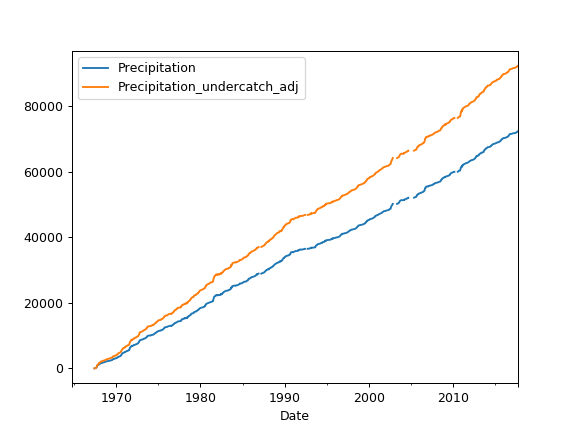

In [31]:
small_dat=dat[['Precipitation', 'Temperature', 'DOY', 'WindSpeed']+ temp_maxmin_cols].copy()
small_dat.index.name='Date'
small_dat.reset_index(inplace=True)
dat_adj=small_dat.merge(period_of_record_avg_ws_r30, how='left', left_on='DOY', right_on='DOY')

dat_adj=dat_adj.set_index('Date')

#Adjust full record by this smoothed wind time-series

#Define precip phase
dat_adj=wx.define_precip_phase(dat_adj, 'Temperature') #daily dat is a copy of original; original dat remains unedited

#Calculate precip undercatch, using CONSTANT yearly pattern of wind speed
dat_adj=wx.correct_undercatch_yang98(dat_adj, 'Precipitation', 'phase', 'WS_Constant', inplace=False)
dat_adj[['Precipitation', 'Precipitation_undercatch_adj']].cumsum().plot()

In [32]:
dat_adj.head()

,Precipitation,Temperature,DOY,WindSpeed,Temp_min,Temp_max,WS_Constant,phase,Precipitation_undercatch_adj
Date,,,,,,,,,
1964-10-01,NaN,NaN,274,NaN,NaN,NaN,3.504864,NaN,NaN
1964-10-02,NaN,NaN,275,NaN,NaN,NaN,3.472277,NaN,NaN
1964-10-03,NaN,NaN,276,NaN,NaN,NaN,3.430628,NaN,NaN
1964-10-04,NaN,NaN,277,NaN,NaN,NaN,3.410073,NaN,NaN
1964-10-05,NaN,NaN,278,NaN,NaN,NaN,3.443896,NaN,NaN


In [33]:
#Rename this column
dat_adj.rename(columns={'Precipitation_undercatch_adj':'Precip_AvgWindSpeed_UndercatchAdj'}, inplace=True)

In [34]:
#Make another, using the REAL daily wind speed
dat_adj=wx.correct_undercatch_yang98(dat_adj, 'Precipitation', 'phase', 'WindSpeed', inplace=False)
dat_adj.rename(columns={'Precipitation_undercatch_adj':'Precip_MeasuredWindSpeed_UndercatchAdj'}, inplace=True)
#Set to NAN before wind speed measured (in fucntion, NANs are filled to keep precip where recorded but wind down)
dat_adj.loc[:dat_adj.WindSpeed.first_valid_index(),'Precip_MeasuredWindSpeed_UndercatchAdj']=pd.np.nan

In [35]:
dat_adj.tail()

,Precipitation,Temperature,DOY,WindSpeed,Temp_min,Temp_max,WS_Constant,phase,Precip_AvgWindSpeed_UndercatchAdj,Precip_MeasuredWindSpeed_UndercatchAdj
Date,,,,,,,,,,
2017-09-26,NaN,NaN,268,NaN,NaN,NaN,3.592762,NaN,NaN,NaN
2017-09-27,NaN,NaN,269,NaN,NaN,NaN,3.594458,NaN,NaN,NaN
2017-09-28,NaN,NaN,270,NaN,NaN,NaN,3.609638,NaN,NaN,NaN
2017-09-29,NaN,NaN,271,NaN,NaN,NaN,3.606415,NaN,NaN,NaN
2017-09-30,NaN,NaN,272,NaN,NaN,NaN,3.565532,NaN,NaN,NaN


In [36]:
#Save this adjusted data
save_pth=base_path + '/Data/' + Glacier + '/AllYears/Wx/LVL3/Undercatch_Adj' + Glacier + '_Daily_Weather.csv'
dat_adj.to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

<IPython.core.display.Javascript object>


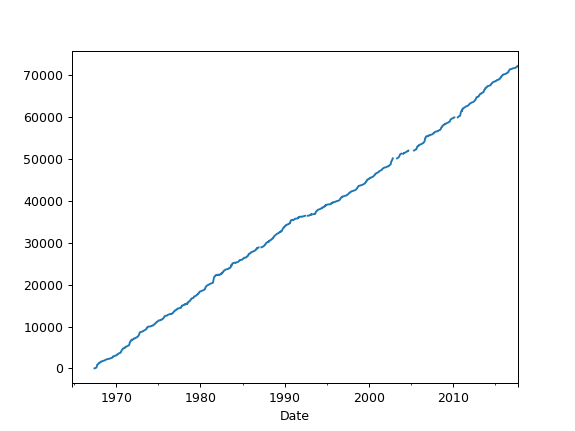

In [37]:
# Rain-snow fraction plot
plt.figure()
dat_adj.Precipitation.cumsum().plot()

In [38]:
precip_col='Precip_AvgWindSpeed_UndercatchAdj'
dat_adj['snow']=pd.np.nan #dat_adj.loc[dat_adj.phase=='snow', precip_col]
dat_adj['rain']=pd.np.nan #dat_adj.loc[dat_adj.phase=='rain', precip_col]

dat_adj['scale_factor_for_mixed_Fsnow']=pd.np.nan
dat_adj.loc[dat_adj.phase=='mixed', 'scale_factor_for_mixed_Fsnow']=((dat_adj.loc[dat_adj.phase=='mixed', 'Temperature'])/-4 + 0.75)
dat_adj.loc[dat_adj.phase=='rain', 'scale_factor_for_mixed_Fsnow']=0
dat_adj.loc[dat_adj.phase=='snow', 'scale_factor_for_mixed_Fsnow']=1

dat_adj['snow']=dat_adj[precip_col]*dat_adj.scale_factor_for_mixed_Fsnow

dat_adj['rain']=dat_adj[precip_col]*(1-dat_adj.scale_factor_for_mixed_Fsnow)

dat_adj['fSnow']=dat_adj.snow/dat_adj[precip_col]

In [39]:
#add numeric date
dat_adj['decimal_date']=dat_adj.index.year+ (dat_adj.index.dayofyear -1)/365

In [41]:
save_pth=base_path + '/Data/' + Glacier + '/AllYears/Wx/LVL3/RainSnowFractionData_' + Glacier + Station+ '.csv'
dat_adj[['Precipitation', 'Temperature','phase', 'WindSpeed', 'WS_Constant',
         'Precip_AvgWindSpeed_UndercatchAdj', 'Precip_MeasuredWindSpeed_UndercatchAdj', 'snow', 'rain','decimal_date']].to_csv(save_pth)

In [42]:
#dat_adj_og=dat_adj.copy()
#dat_adj=dat_adj_og.copy()

In [45]:
#Aggregate monthly data & plot

#FIRST! Subset to only winter months (following Harpold 2012 trend paper)
dat_adj['month']=dat_adj.index.month
dat_adj=dat_adj[dat_adj.month.isin([6,7,8])]#isin([11,12,1,2,3])]


mth_dat=pd.DataFrame()
mth_dat['snow']=wx.aggregate_time_with_threshold(dat_adj['snow'], 'M', func='sum', steps_in_period=30)
mth_dat['rain']=wx.aggregate_time_with_threshold(dat_adj['rain'], 'M', func='sum', steps_in_period=30)
mth_dat['Precipitation']=wx.aggregate_time_with_threshold(dat_adj['Precipitation'], 'M', func='sum', steps_in_period=30)

#calculate snow fraction
mth_dat['fSnow']=mth_dat['snow']/(mth_dat['rain']+mth_dat['snow'])

#Add decimal date
mth_dat['decimal_date']=mth_dat.index.year+ (mth_dat.index.dayofyear -1)/365

In [46]:
mth_dat.tail()
import plot_funcs

In [47]:
# plot_funcs.OLS_plot('decimal_date', 'Precipitation', dat=mth_dat.dropna(subset=['Precipitation']), title='Monthly '+ 'fSnow, Nov-Mar', aspect=2.5)
# plt.savefig('./figs/trends/' + Glacier + Station+ '_Monthly_fSnowTrend_WINTER' +'.jpg')

In [48]:
dat_adj.tail()

,Precipitation,Temperature,DOY,WindSpeed,Temp_min,Temp_max,WS_Constant,phase,Precip_AvgWindSpeed_UndercatchAdj,Precip_MeasuredWindSpeed_UndercatchAdj,snow,rain,scale_factor_for_mixed_Fsnow,fSnow,decimal_date,month
Date,,,,,,,,,,,,,,,,
2017-08-27,NaN,NaN,238,NaN,NaN,NaN,3.880500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.652055,8
2017-08-28,NaN,NaN,239,NaN,NaN,NaN,3.901472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.654795,8
2017-08-29,NaN,NaN,240,NaN,NaN,NaN,3.902722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.657534,8
2017-08-30,NaN,NaN,241,NaN,NaN,NaN,3.942028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.660274,8
2017-08-31,NaN,NaN,242,NaN,NaN,NaN,3.970861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.663014,8


In [49]:
#Aggregate yearly data & plot

dat_adj['month']=dat_adj.index.month
dat_adj=dat_adj[dat_adj.month.isin([11,12,1,2,3])]

yr_dat=pd.DataFrame()
yr_dat['snow']=wx.aggregate_time_with_threshold(dat_adj['snow'], 'AS', func='sum', steps_in_period=150)
yr_dat['rain']=wx.aggregate_time_with_threshold(dat_adj['rain'], 'AS', func='sum', steps_in_period=150)

#calculate snow fraction
yr_dat['fSnow']=yr_dat['snow']/(yr_dat['rain']+yr_dat['snow'])

#Add decimal date
yr_dat['decimal_date']=yr_dat.index.year+ (yr_dat.index.dayofyear -1)/365


plot_funcs.OLS_plot('decimal_date', 'fSnow', dat=yr_dat.dropna(subset=['fSnow']), title='Yearly '+ 'fSnow', aspect=2.5)
#plt.savefig('./figs/trends/' + Glacier + Station+ '_Yearly_fSnowTrend' +'.jpg')

ValueError: zero-size array to reduction operation maximum which has no identity

Trend Analysis

In [99]:
import plot_funcs
import CleanWxData
import seaborn as sns
import statsmodels.api as sm
sns.set_palette("Set2")
sns.set(style='whitegrid') #set seaborn figure size to A4 paper

In [100]:
dat['decimal_date']=dat.index.year+ (dat.index.dayofyear -1)/365

In [101]:
dat.head(1)

,temp_original,precip_original,Temp_USGS,Stage_Precip,TPG_Precip,WindSpeed,Temp_min,Temp_max,Precipitation,stage_adjusted,original_adjusted,Temperature,DOY,decimal_date
Date,,,,,,,,,,,,,,
1964-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274,1964.750685


In [48]:
dat.columns

Index(['temp_original', 'precip_original', 'Temp_USGS', 'Stage_Precip',
       'TPG_Precip', 'WindSpeed', 'Temp_min', 'Temp_max', 'Precipitation',
       'stage_adjusted', 'original_adjusted', 'Temperature', 'DOY'],
      dtype='object')

<IPython.core.display.Javascript object>


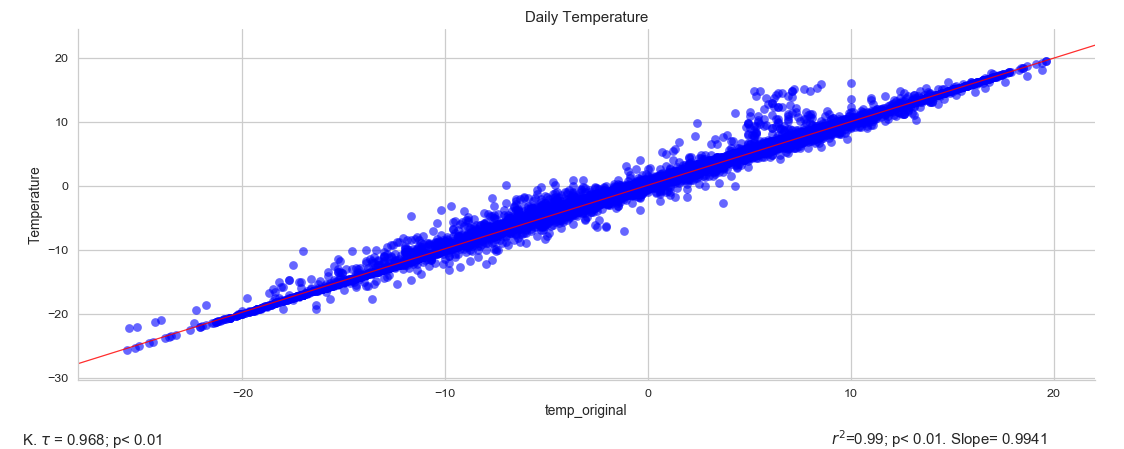

In [102]:
#Simple  OLS plot of old vs new precip
#var='Precipitation'
var='Temperature'
if var=='Temperature':
    var_old='temp_original'
    agg_func='mean'
if var=='Precipitation':
    var_old='precip_original'
    agg_func='sum'
sns.set(rc={'figure.figsize':(12, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot(var_old, var, dat=dat.dropna(subset=[var]), title='Daily '+ var, aspect=2.5)
if save_plots:
    plt.savefig('./figs/precip_match/' + Glacier + Station+ '_Compare2preciprecords_'+ var +'.jpg')

In [52]:
#Aggregate monthly data
mth_dat=pd.DataFrame()
mth_dat[var]=wx.aggregate_time_with_threshold(dat[var], 'M', func=agg_func, steps_in_period=30)

#Add decimal date
mth_dat['decimal_date']=mth_dat.index.year+ (mth_dat.index.dayofyear -1)/365

In [53]:
print(len(mth_dat[var]['1967':][mth_dat[var]['1967':].isnull()]))

len(mth_dat[var]['1967':][mth_dat[var]['1967':].notnull()])

68


541

p= 0.29


<IPython.core.display.Javascript object>


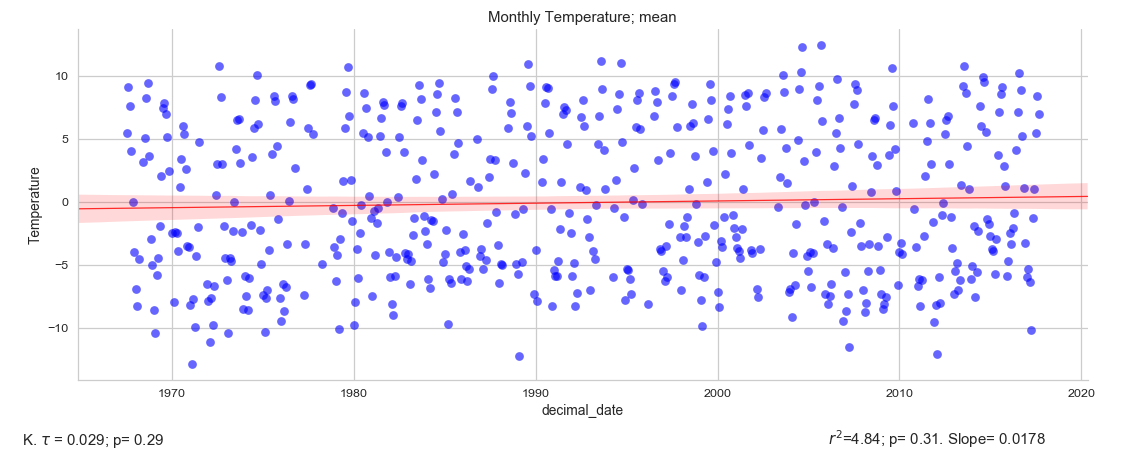

p= 0.31


In [54]:
#Simple  OLS plot of monthly data
sns.set(rc={'figure.figsize':(6, 12)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', var, dat=mth_dat.dropna(subset=[var]), title='Monthly '+ var + "; "+ agg_func, aspect=2.5)
#if save_plots:
plt.savefig('./figs/trends/' + Glacier + Station+ '_OLS_MonthlyTrend21_'+ var +'.jpg')

p= 0.14


<IPython.core.display.Javascript object>


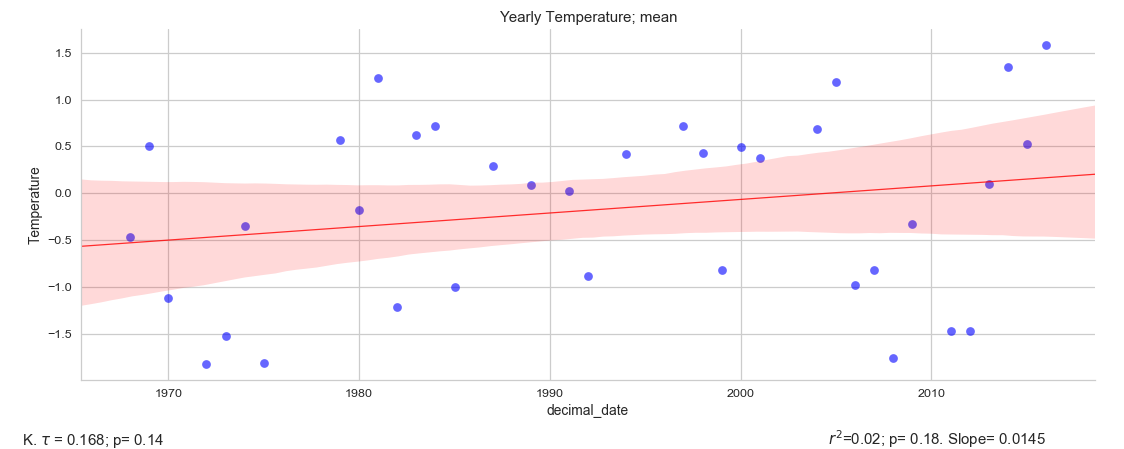

p= 0.18


In [55]:
#Aggregate to yearly data
y_dat=pd.DataFrame()
y_dat[var]=wx.aggregate_time_with_threshold(dat[var], 'AS', func=agg_func, steps_in_period=365)
#Add decimal date
y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

#y_dat.loc['1978':'1981', 'Precipitation']=pd.np.nan #see what happens w/o 1980 PDO bump

#Simple  OLS plot
sns.set(rc={'figure.figsize':(12, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', var, dat=y_dat.dropna(subset=[var]), title='Yearly '+ var + "; "+ agg_func, aspect=2.5)
if save_plots:
    plt.savefig('./figs/trends/' + Glacier + Station+ '_OLS_Annual_2'+ var +'.jpg')

In [49]:
len(y_dat.Precipitation['1967':])

51

In [50]:
print(len(y_dat.Precipitation['1967':][y_dat.Precipitation['1967':].isnull()]))
len(y_dat.Precipitation['1967':][y_dat.Precipitation['1967':].notnull()])

16


35

In [51]:
# mth_dat['month']=mth_dat.index.month
# mth_dat['year']=mth_dat.index.year
# g=sns.factorplot(x='year', y=var, hue='month', row='month', data=mth_dat, kind='point', aspect=5)
# plt.xticks(rotation=-90)
# if save_plots:
#     plt.savefig('./figs/trends/' + Glacier + Station+ '_ScatterByMonthThruTime_'+ var +'.jpg')

In [52]:
# plt.figure()
# #sns.set(rc={'figure.figsize':(12, 6)}) #set seaborn figure size to A4 paper
# g=sns.boxplot(x=mth_dat.index.year, y=var, data=mth_dat)
# plt.xticks(rotation=-90)

In [53]:
#Find missing values and fill
var_filled=dat[var].interpolate()
var_filled=var_filled[var_filled.first_valid_index():]

#Deal with adding dates to x-axis
jan1s=var_filled.index[var_filled.index.dayofyear==1]
jan1_labels=jan1s.year
idx_jan1s=[var_filled.index.get_loc(x) for x in jan1s]


C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


<IPython.core.display.Javascript object>


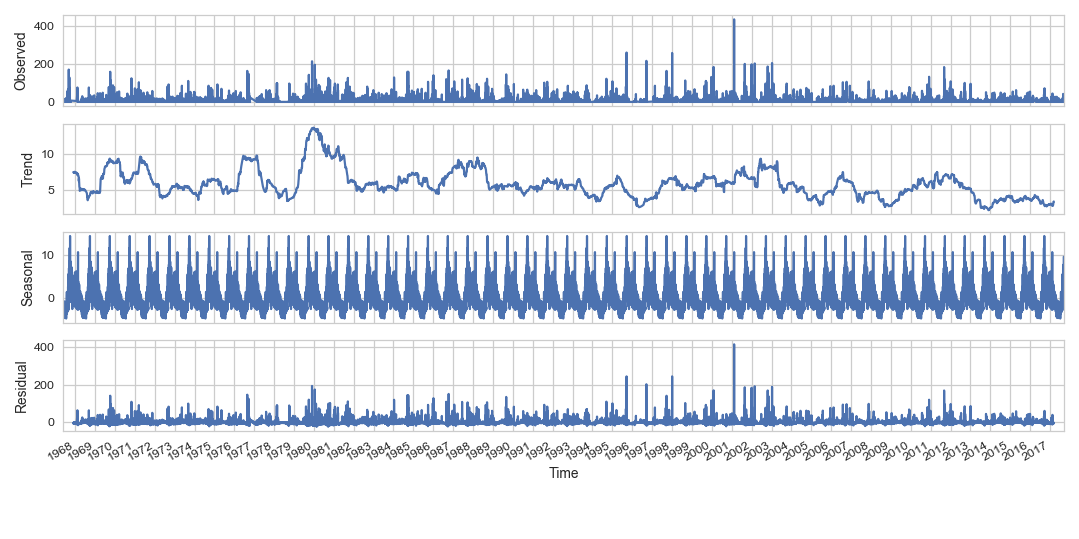

In [54]:
#Make decomposition plot
decomposition= sm.tsa.seasonal_decompose(var_filled.values, model='additive', freq=365) #frequency is yearly, but must be integer
fig = decomposition.plot()
my_xticks=jan1_labels
plt.xticks(idx_jan1s, my_xticks)
plt.show()
fig.autofmt_xdate()
plt.savefig("./figs/seasonal_trend_decompositon_3"+ var+ "_"+ Glacier + Station+ ".jpg")

In [72]:
df=pd.DataFrame(decomposition.trend)
df.columns=['trend']

In [73]:
df=df.reset_index()

In [74]:
df['year']=df.index/365

<IPython.core.display.Javascript object>


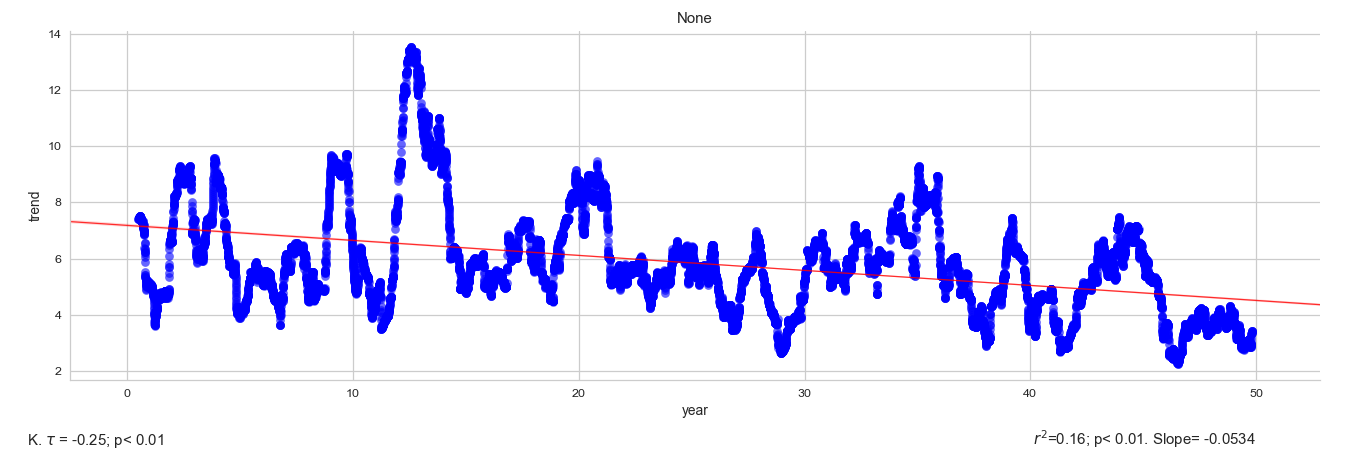

In [76]:
plot_funcs.OLS_plot("year", "trend", df)

<IPython.core.display.Javascript object>


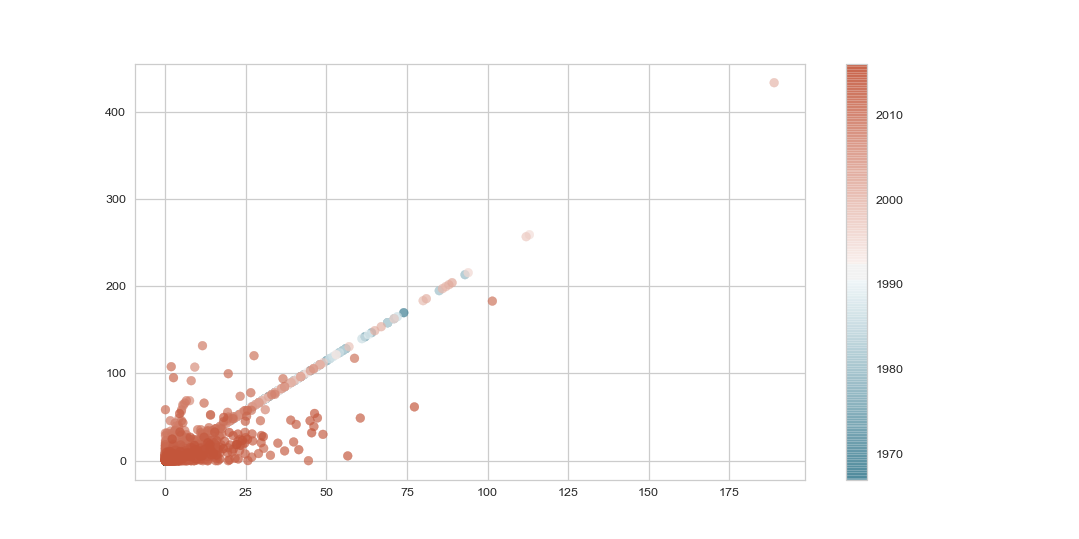

In [77]:
#Colored by date
f, ax = plt.subplots()
#cmap = sns.cubehelix_palette(as_cmap=True)
cmap=sns.diverging_palette(220, 20, n=7, as_cmap=True)
points = ax.scatter(dat.precip_original, dat.Precipitation, c=dat.index.year, s=50, cmap=cmap, alpha=0.7)
f.colorbar(points)
plt.xlabel="Original Precip"
plt.ylabel="New Precip"
if save_plots:
    plt.savefig('./figs/precip_match/' + Glacier + Station+ '_GUI vs New Colored by Year2.jpg')

<IPython.core.display.Javascript object>


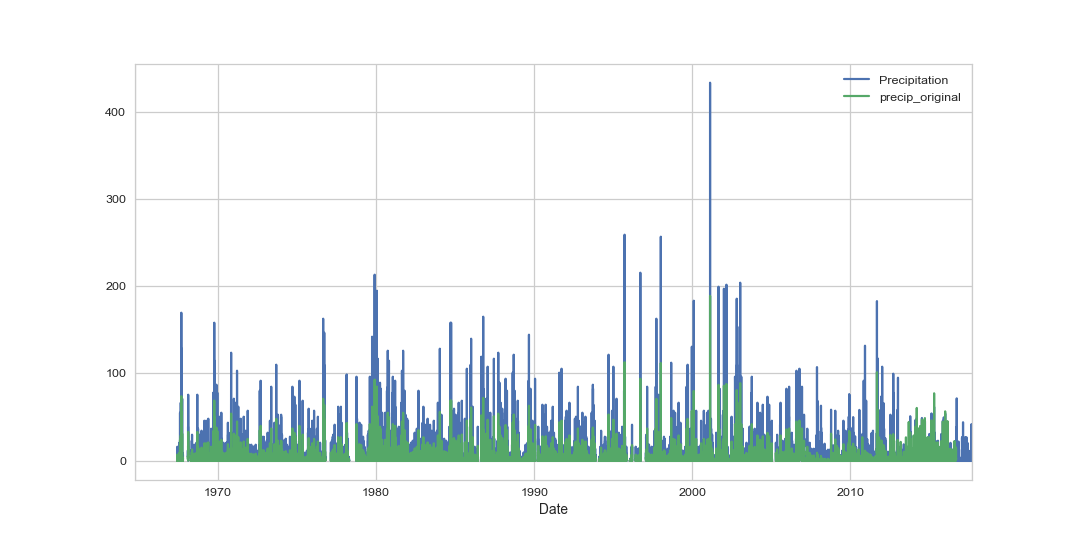

In [78]:
dat[['Precipitation', 'precip_original']].plot()

In [79]:
#save_dat.to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

In [62]:
dat_adj['ratio']=dat_adj.Precipitation_undercatch_adj/dat_adj.Precipitation

<IPython.core.display.Javascript object>


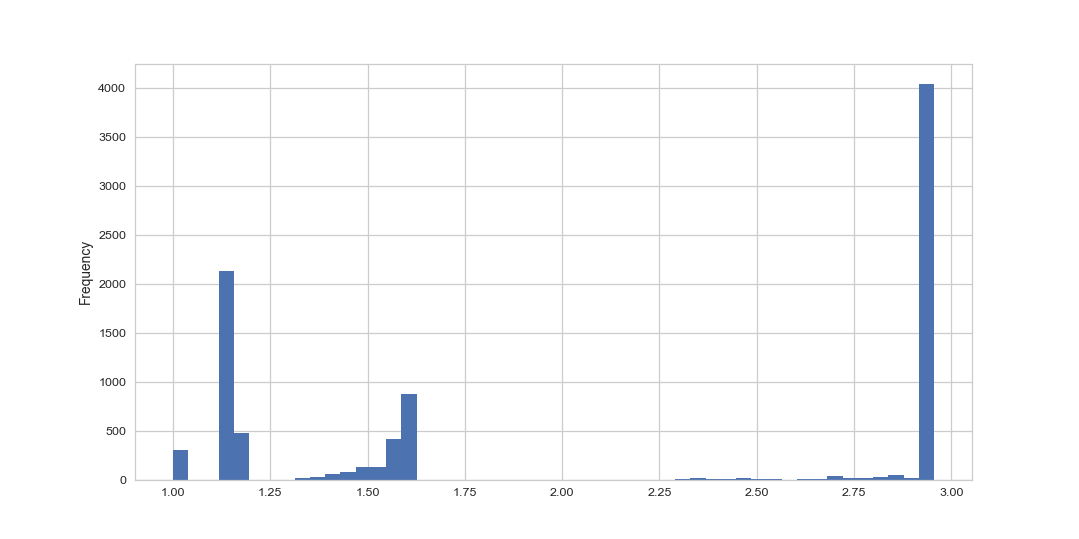

In [67]:
plt.figure()
dat_adj.ratio.plot(kind='hist', bins=50)

p= 0.05


<IPython.core.display.Javascript object>


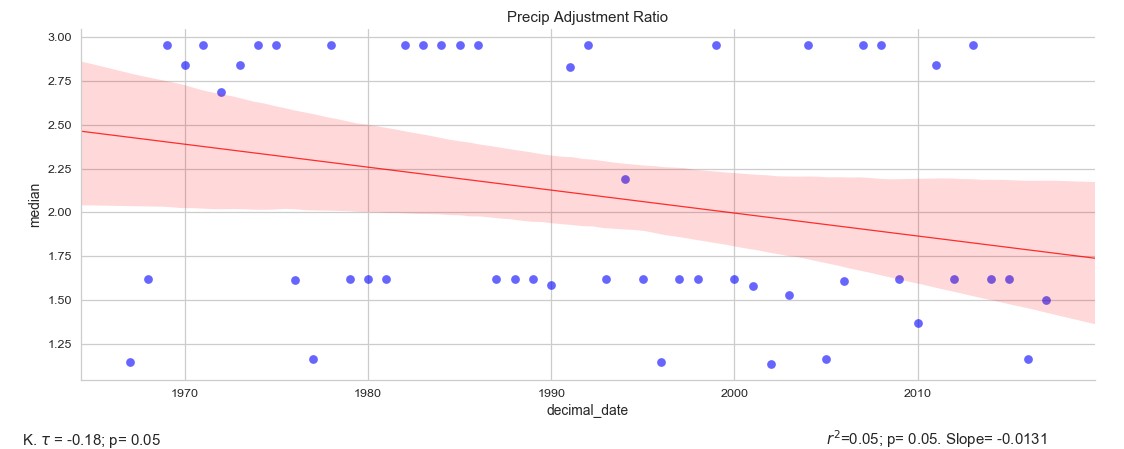

p= 0.05


In [68]:
#Aggregate Ratio yearly data
var='ratio'
y_dat=dat_adj.ratio.resample('AS', convention='start').agg(['median', 'count'])

#Add decimal date
y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

#y_dat.loc['1978':'1981', 'Precipitation']=pd.np.nan #see what happens w/o 1980 PDO bump

#Simple  OLS plot
sns.set(rc={'figure.figsize':(6, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', 'median', dat=y_dat.dropna(subset=['median']), title='Precip Adjustment Ratio', aspect=2.5)
# if save_plots:
#     plt.savefig('./figs/trends/' + Glacier + Station+ '_trendInThePrecipAdjustmentFactor'+ var +'.jpg')

In [ ]:
dat.join(dat_adj, t)

In [70]:
dat_adj.ratio.max()

2.9554664449562109

In [85]:
dat_adj[var]

Date
1964-10-01         NaN
1964-10-02         NaN
1964-10-03         NaN
1964-10-04         NaN
1964-10-05         NaN
1964-10-06         NaN
1964-10-07         NaN
1964-10-08         NaN
1964-10-09         NaN
1964-10-10         NaN
1964-10-11         NaN
1964-10-12         NaN
1964-10-13         NaN
1964-10-14         NaN
1964-10-15         NaN
1964-10-16         NaN
1964-10-17         NaN
1964-10-18         NaN
1964-10-19         NaN
1964-10-20         NaN
1964-10-21         NaN
1964-10-22         NaN
1964-10-23         NaN
1964-10-24         NaN
1964-10-25         NaN
1964-10-26         NaN
1964-10-27         NaN
1964-10-28         NaN
1964-10-29         NaN
1964-10-30         NaN
                ...   
2017-08-11    1.125979
2017-08-12    1.125856
2017-08-13    1.125884
2017-08-14         NaN
2017-08-15    1.129414
2017-08-16    1.130828
2017-08-17    1.132554
2017-08-18    1.134050
2017-08-19    1.134059
2017-08-20    1.133784
2017-08-21    1.133917
2017-08-22    1.135223
2017-0

p= 0.05


<IPython.core.display.Javascript object>


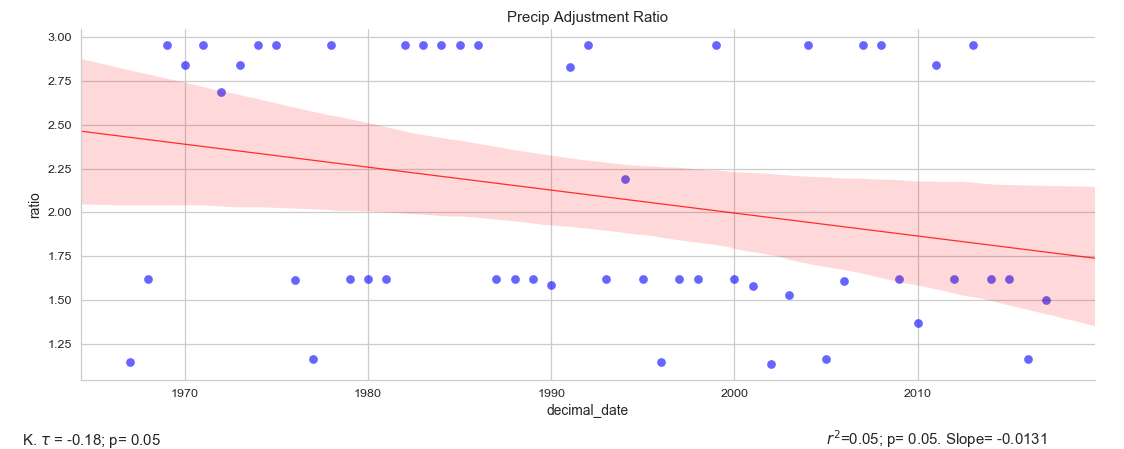

p= 0.05


In [94]:
#Aggregate to yearly data
var='ratio'
#y_dat=dat_adj.ratio.resample('AS', convention='start').agg(['sum', 'count'])
y_dat=pd.DataFrame()
y_dat[var]=wx.aggregate_time_with_threshold(dat_adj[var], 'AS', func='median', steps_in_period=365, threshold=0.1)
#Add decimal date
y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

#y_dat.loc['1978':'1981', 'Precipitation']=pd.np.nan #see what happens w/o 1980 PDO bump

#Simple  OLS plot
sns.set(rc={'figure.figsize':(6, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', var, dat=y_dat.dropna(subset=[var]), title='Precip Adjustment Ratio', aspect=2.5)
# if save_plots:
#     plt.savefig('./figs/trends/' + Glacier + Station+ '_trendInThePrecipAdjustmentFactor'+ var +'.jpg')

In [80]:
y_dat.tail()

,ratio,decimal_date
Date,,
2013-01-01,NaN,2013.0
2014-01-01,NaN,2014.0
2015-01-01,NaN,2015.0
2016-01-01,NaN,2016.0
2017-01-01,NaN,2017.0


<IPython.core.display.Javascript object>


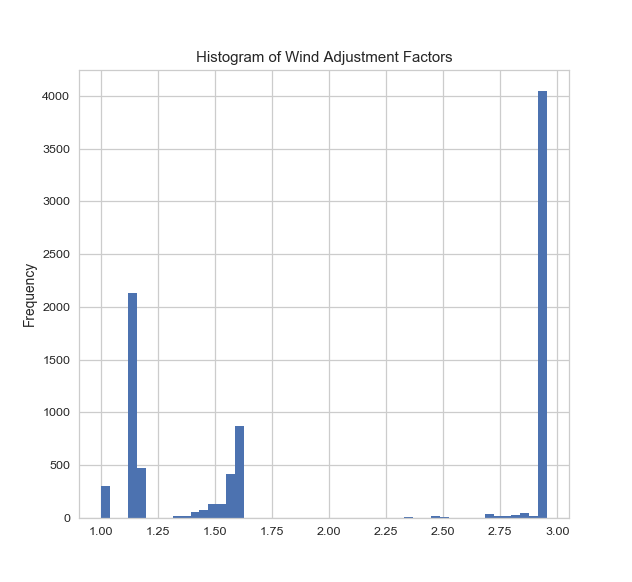

In [88]:
sns.set(rc={'figure.figsize':(6, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
plt.figure()
dat_adj.ratio.plot(kind='hist', bins=50)
plt.title("Histogram of Wind Adjustment Factors")

In [ ]:
y_dat.dropna()

<IPython.core.display.Javascript object>


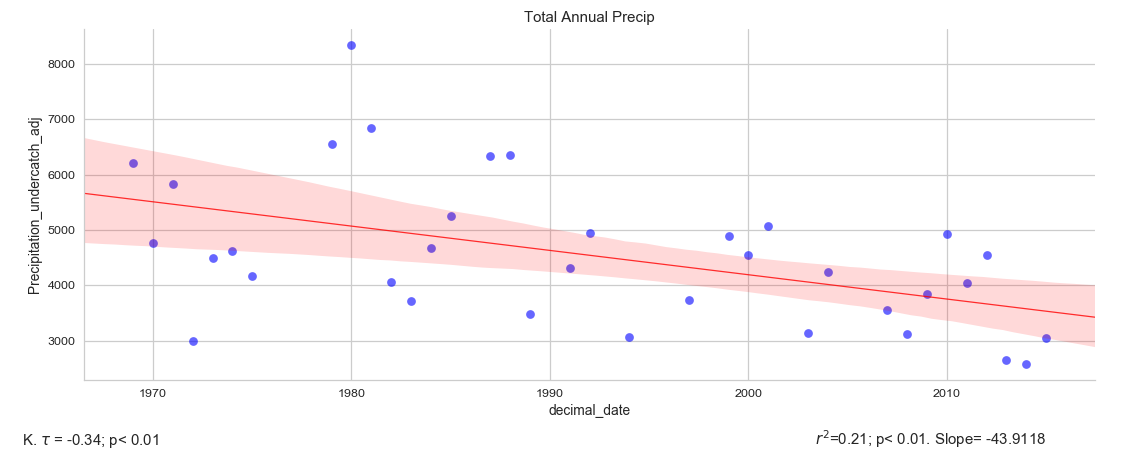

In [95]:
#Aggregate to yearly data
var='Precipitation_undercatch_adj'
y_dat=pd.DataFrame()
y_dat[var]=wx.aggregate_time_with_threshold(dat_adj[var], 'AS', func='sum', steps_in_period=365)
#Add decimal date
y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

#y_dat.loc['1978':'1981', 'Precipitation']=pd.np.nan #see what happens w/o 1980 PDO bump

#Simple  OLS plot
sns.set(rc={'figure.figsize':(12, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', var, dat=y_dat.dropna(subset=[var]), title='Total Annual Precip', aspect=2.5)
if save_plots:
    plt.savefig('./figs/trends/' + Glacier + Station+ '_OLS_WindAdjustedYearly'+ var +'.jpg')

In [96]:
save_plots

True

In [20]:
dat.head()

,temp_original,precip_original,Temp_USGS,Stage_Precip,TPG_Precip,WindSpeed,Precipitation,stage_adjusted,original_adjusted,Temperature
Date,,,,,,,,,,
1964-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Something is messed up in this block; must be mulitplying by scale factor a few times or something? Confusing.

# dat['Stage_Adj']=dat.Stage_Precip*scale_factor #digital data, 2003 -> present
# GUI_dat['precip_original']=GUI_dat.precip_original*scale_factor #pre-digital era

# dat[precip_cols+ ['Stage_Adj', 'precip_original']][start_good_overlap_precip_date:].cumsum().plot()

# ### Combine the 2 gages into a continous record of digital time (2003 -> present)
# dat['Precipitation']=dat['TPG_Precip']
# dat.loc[dat.index<start_good_overlap_precip_date, 'Precipitation']=pd.np.nan #set TPG records before final wind screen to NAN

# dat.loc[dat.Precipitation.isnull(), 'Precipitation']=dat.Stage_Adj #this is digital-era scaled precip

# #Plot to ensure that full digital precip record is captured as we want
# plt.figure()
# raw_data=(raw_dat.StageCumulative*1000*5*scale_factor)
# ax=raw_data.plot(color='grey')
# dat[['Precipitation', 'TPG_Precip', 'Stage_Precip', 'Stage_Adj']].cumsum().plot(ax=ax)

# plt.ylim(-10, 25000)

# Merge older data with new 15-min derived daily data
# dat=GUI_dat[['temp_original', 'precip_original']].merge(dat[[temp_col]+ precip_cols+['Precipitation']+ [wind_col]], left_index=True, right_index=True, how='outer')

# #Create single continuous precipitation record
# dat['Precip_All']=dat['Precipitation'] #this will hold precip from 2003-09-14 (first day of digital precip) _> present, and prior records before

# use_Mayo_data=dat.Precipitation.first_valid_index()-datetime.timedelta(days=1)
# dat.loc[:use_Mayo_data, "Precip_All"]=dat.loc[:use_Mayo_data, 'precip_original']